In [1]:
!pip install yahoo_finance_api2

  Created wheel for yahoo-finance-api2: filename=yahoo_finance_api2-0.0.8-cp36-none-any.whl size=3695 sha256=14ca6e36d7afcb7a0cfab30a0e05e95fda988580403f3083dfea17d14fc4cce8
  Stored in directory: /root/.cache/pip/wheels/af/fc/9e/54be65b5ff75f526b464837f8a6b0ee521e545c59b219bd862
  Created wheel for pprint: filename=pprint-0.1-cp36-none-any.whl size=1250 sha256=eeb3e8b6b0d2ece050d0a7de2a088f201f5c9c3bb9f5d960c39b71bd29a07a9f
  Stored in directory: /root/.cache/pip/wheels/42/d4/c6/16a6495aecc1bda5d5857bd036efd50617789ba9bea4a05124
Successfully built yahoo-finance-api2 pprint


In [2]:
import pandas as pd
import sys
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
from datetime import datetime

def dataloader(stock_name):
  my_share = share.Share(stock_name)
  symbol_data = None

  try:
      symbol_data = my_share.get_historical(share.PERIOD_TYPE_YEAR,30,
                                            share.FREQUENCY_TYPE_DAY,1)
      print(stock_name+" has been downloaded")
      
  except YahooFinanceError as e:
      print(e.message)
      sys.exit(1)
  df = pd.DataFrame(symbol_data)
  
  df['timestamp'] = [datetime.fromtimestamp(t/1000) for t in df['timestamp']]

  # test = df[(df['timestamp'] >= '2016-1-1 01:00:00') & (df['timestamp'] <= '2018-12-31 04:00:00')]
  return df[(df['timestamp'] >= '1995-1-1 01:00:00') & (df['timestamp'] <= '2018-12-31 04:00:00')]

print(dataloader("AAPL"))

AAPL has been downloaded
               timestamp        open  ...       close     volume
1298 1995-01-03 14:30:00    1.388393  ...    1.370536   25967200
1299 1995-01-04 14:30:00    1.379464  ...    1.406250   39670400
1300 1995-01-05 14:30:00    1.401786  ...    1.388393   18410000
1301 1995-01-06 14:30:00    1.486607  ...    1.500000  269155600
1302 1995-01-09 14:30:00    1.486607  ...    1.471540   68521600
...                  ...         ...  ...         ...        ...
7334 2018-12-21 14:30:00  156.860001  ...  150.729996   95744600
7335 2018-12-24 14:30:00  148.149994  ...  146.830002   37169200
7336 2018-12-26 14:30:00  148.300003  ...  157.169998   58582500
7337 2018-12-27 14:30:00  155.839996  ...  156.149994   53117100
7338 2018-12-28 14:30:00  157.500000  ...  156.229996   42291400

[6041 rows x 6 columns]


In [0]:
import numpy as np
import math

def get_data(stock_name):
    df = dataloader(stock_name)
    train = list(df[(df['timestamp'] >= '1995-01-01 01:00:00') & (df['timestamp'] <= '2015-12-31 04:00:00')]['close'])
    # train2 = train[:-(len(train)%window_size)]
    test = list(df[(df['timestamp'] >= '2016-01-01 01:00:00') & (df['timestamp'] <= '2016-12-31 12:00:00')]['close'])
    # test2 = test[:-(len(test)%window_size)]
    return train, test

AAPL has been downloaded


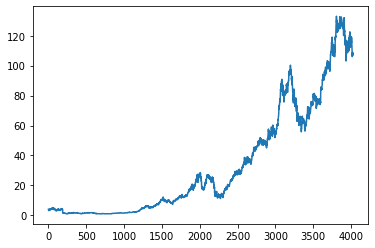

In [4]:
import matplotlib.pyplot as plt

train_data,_ = get_data("AAPL")

plt.plot([i for i in range(len(train_data))], train_data)

In [0]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import GaussianNoise
from keras.models import Model
from keras.losses import mean_absolute_error
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from keras.optimizers import Adagrad
import keras.backend as K

from keras.utils.vis_utils import plot_model

def CNN_model():
  #The CNN builder
  #It is a sequential model, layers are added successively

  conv_NN = Sequential()

  #A gaussian noise to focus on the trend and not a too much precise prediction
  #Beware Gaussian noise layers are activated only during the learning phase. 
  conv_NN.add(
      GaussianNoise(input_shape=(10,1,), stddev=10, name="Noise")
  )

  #The convolutional layers to focus on pattern recognition.
  conv_NN.add(
      Conv1D(
          filters=10,
          kernel_size=3,
          activation='tanh',
          name='conv_1'
      )
  )

  conv_NN.add(
      Conv1D(
          filters=20,
          kernel_size=3,
          activation='relu',
          name='conv_2'
      )
  )

  conv_NN.add(MaxPooling1D(pool_size=2, name='pool_minutes'))
  conv_NN.add(Dropout(0.2, name="Dropout"))
  conv_NN.add(Flatten(name='Flatten'))


  #Final regressions after convolutional process.
  conv_NN.add(
      Dense(
          units=32,
          activation='relu',
          name='dense1' 
      )
  )

  conv_NN.add(
      Dense(
          units=1,
          activation='relu',
          name='output' 
      )
  )

  conv_NN.compile(
      loss= 'mse',
      optimizer=Adam()
  )

  return(conv_NN)

In [6]:
t_data, v_data = get_data("AAPL")

train_data = []
res_train = []
valid_data = []
res_valid = []

for i in range(len(t_data) - 11):
  data = []
  for j in range(10):
    data.append([ t_data[i+j] ])
  train_data.append(np.array(data))
  res_train.append(t_data[i+10])

for i in range(len(v_data) - 11):
  data = []
  for j in range(10):
    data.append([ v_data[i+j] ])
  valid_data.append(np.array(data))
  res_valid.append(v_data[i+10])


AAPL has been downloaded


In [19]:
model = CNN_model()

#Time to train
model.fit(
    x = np.array(train_data),
    y = np.array(res_train),
    verbose=1,
    validation_data=(np.array(valid_data), res_valid),
    epochs=15,
    batch_size=30
)

Train on 4013 samples, validate on 241 samples
Epoch 1/15
4013/4013 [==============================] - 1s 307us/step - loss: 1132.3557 - val_loss: 429.0182
Epoch 2/15
4013/4013 [==============================] - 1s 132us/step - loss: 163.2523 - val_loss: 57.2643
Epoch 3/15
4013/4013 [==============================] - 1s 133us/step - loss: 136.7640 - val_loss: 58.0957
Epoch 4/15
4013/4013 [==============================] - 1s 125us/step - loss: 125.9726 - val_loss: 211.8073
Epoch 5/15
4013/4013 [==============================] - 1s 126us/step - loss: 100.7503 - val_loss: 59.0003
Epoch 6/15
4013/4013 [==============================] - 1s 145us/step - loss: 87.9697 - val_loss: 56.9744
Epoch 7/15
4013/4013 [==============================] - 1s 161us/step - loss: 75.5669 - val_loss: 502.0672
Epoch 8/15
4013/4013 [==============================] - 1s 154us/step - loss: 70.3964 - val_loss: 67.0717
Epoch 9/15
4013/4013 [==============================] - 1s 126us/step - loss: 65.8826 - val_loss

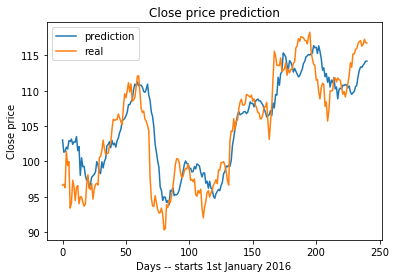

In [20]:
plot_data = []

for i in range(len(valid_data)):
  prediction = model.predict(
      x = np.array([valid_data[i]]),
      verbose=0,
      batch_size=1
  )
  plot_data.append(prediction[0])

plt.plot([i for i in range(len(valid_data))], plot_data, label="prediction")
plt.plot([i for i in range(len(valid_data))], res_valid, label="real")
plt.legend()
plt.title("Close price prediction")
plt.xlabel("Days -- starts 1st January 2016 ")
plt.ylabel("Close price")
plt.show()